In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim

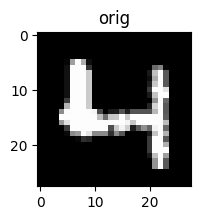

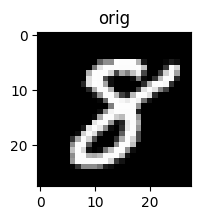

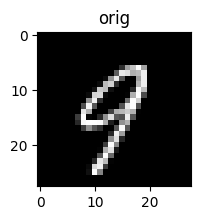

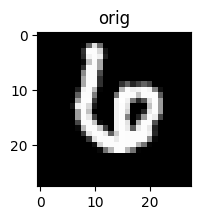

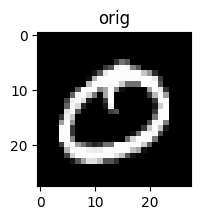

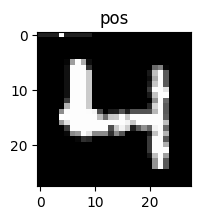

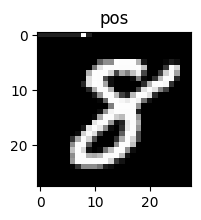

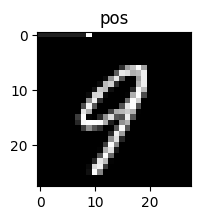

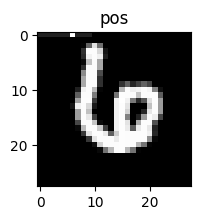

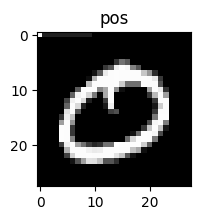

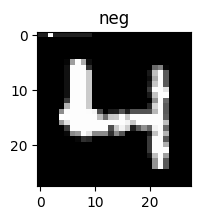

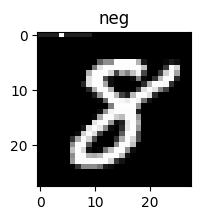

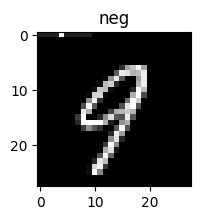

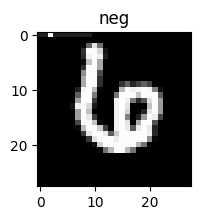

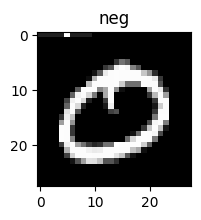

training layer 0 ...


100%|██████████| 1000/1000 [00:46<00:00, 21.55it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:31<00:00, 31.40it/s]


train error: 0.08352500200271606
train accuracy: 0.9164749979972839
test error: 0.08270001411437988
test accuracy: 0.9172999858856201


In [11]:

def overlay_y_on_x(x, y):
    x_c = x.clone()
    x_c[:, :10] *= 0.0
    x_c[range(x.shape[0]), y] = x.max()
    return x_c


class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]
    '''In this part, for each label, the model calculates the "goodness"
     of the input data for that label. It iteratively passes the data through
     the layers of the neural network (self.layers) and calculates the
     squared mean of the output.The final "goodness" for each label is the
     sum of these values.'''
    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)


class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.02)
        self.threshold = 1.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)#+1e-4 to not be zoero
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([
                self.threshold -g_pos  ,
                g_neg - self.threshold]))).mean()#measuring loss
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


torch.manual_seed(1234)
transform = Compose([
        ToTensor(),
        Normalize((0.1300,), (0.3000,)),
        Lambda(lambda x: torch.flatten(x))])

train_loader = DataLoader(
    MNIST('./data/', train=True,
          download=True,
          transform=transform),
    batch_size=40000, shuffle=True)

test_loader = DataLoader(
    MNIST('./data/', train=False,
          download=True,
          transform=transform),
    batch_size=10000, shuffle=False)


net = Net([784, 500, 500])
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()
x_pos = overlay_y_on_x(x, y)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])

for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    for idx in range(5):
        reshaped = data[idx].cpu().reshape(28, 28)
        plt.figure(figsize=(2, 2))
        plt.title(name)
        plt.imshow(reshaped, cmap="gray")
        plt.show()

net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())
train_accuracy = net.predict(x).eq(y).float().mean().item()
print('train accuracy:', train_accuracy)
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())
test_accuracy = net.predict(x_te).eq(y_te).float().mean().item()
print('test accuracy:', test_accuracy)



why this loss function satisfy the goodness necessery condition:

1-Separation of Positive and Negative Samples: The term self.threshold - g_pos tries to make the goodness of the positive sample greater than a specified threshold (self.threshold), encouraging a separation between the positive and negative samples.

2-Separation of Negative and Positive Samples: The term g_neg - self.threshold similarly tries to make the goodness of the negative sample smaller than the negative of the specified threshold (-self.threshold), further enforcing the separation.

3-Logistic Transformation: The entire expression is passed through a logistic function (torch.log(1 + torch.exp(torch.cat([self.threshold -g_pos  ,
g_neg - self.threshold])))). The logistic function is often used to convert raw scores into probabilities. In this case, it introduces a smoothness property and helps in penalizing large deviations from the specified margin.

4-Mean Reduction: Finally, the mean of the resulting values is taken. This is a common practice in training deep learning models. It computes the average loss over the entire batch, making the loss value independent of the batch size.

 Here is the explanation of code. with over_lay_o function we implement one hot vector and in net class in predict function we define goodness that I told you how does works. in forward function x_direction normalizes each input row of x to have unit norm by dividing each row by the L2 norm of that row. The +1e-4 is added to the denominator to avoid division by zero. The normalized input x_direction is then multiplied by the transpose of the weight matrix self.weight.T. This operation essentially computes the dot product of the normalized input and the transposed weight matrix. in train, we update the loss which question gave us .

In [7]:
import torch.nn.functional as F

class LinearClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

    def train_weights(self, x, y, num_epochs=100):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.002)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


        for epoch in range(num_epochs):
            optimizer.zero_grad()
            outputs = self(x)
            loss = criterion(outputs, y)

            loss.backward(retain_graph=True)
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    def predict(self, x):
        with torch.no_grad():
            outputs = self(x)
            probabilities = nn.functional.softmax(outputs, dim=1)
            _, predicted_class = torch.max(probabilities, 1)
        return predicted_class
class Netu(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        self.linear_classifier = LinearClassifier(sum(dims)-784, 10)
        self.linear_classifier.to("cuda")

        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]
    '''In this part, for each label, the model calculates the "goodness"
     of the input data for that label. It iteratively passes the data through
     the layers of the neural network (self.layers) and calculates the
     squared mean of the output.The final "goodness" for each label is the
     sum of these values.'''
    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def unsupervised_train(self, x_pos, x_neg2):
        h_pos , h_neg2 = x_pos, x_neg2
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos , h_neg2= layer.unsupervised_train(h_pos, h_neg2)
    def train_last_layer(self,x,y):
        outputs = []
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)
        concatenated_output = torch.cat(outputs, dim=1)
        self.linear_classifier.train_weights(concatenated_output, y)
    def predictunsup(self,x):
      outputs = []
      for layer in self.layers:
            x = layer(x)
            outputs.append(x)
      concatenated_output = torch.cat(outputs, dim=1)
      return self.linear_classifier.predict(concatenated_output)


torch.Size([40000, 784]) lll torch.Size([784])


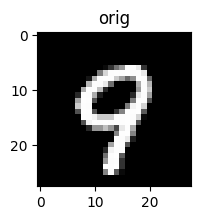

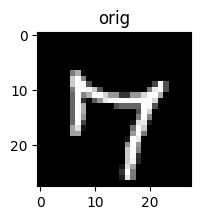

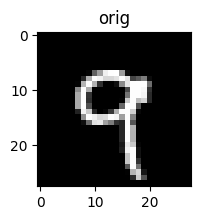

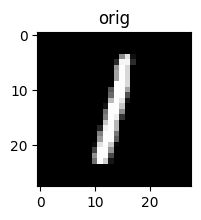

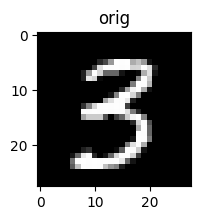

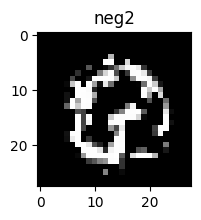

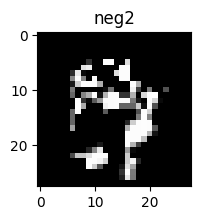

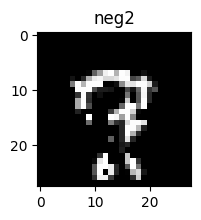

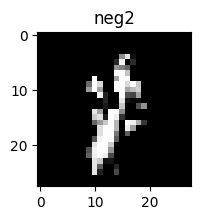

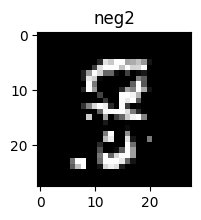

training layer 0 ...


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


training layer 1 ...


100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


Epoch [10/100], Loss: 1.0787
Epoch [20/100], Loss: 0.6444
Epoch [30/100], Loss: 0.4805
Epoch [40/100], Loss: 0.3539
Epoch [50/100], Loss: 0.2906
Epoch [60/100], Loss: 0.2527
Epoch [70/100], Loss: 0.2256
Epoch [80/100], Loss: 0.2053
Epoch [90/100], Loss: 0.1897
Epoch [100/100], Loss: 0.1777


In [9]:


class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def unsupervised_train(self, x_pos, x_neg2):
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg2 = self.forward(x_neg2).pow(2).mean(1)

            loss = torch.log(1 + torch.exp(torch.cat([
                self.threshold - g_pos,
                g_neg2 - self.threshold]))).mean()#g_neg1 - self.threshold,

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

        return self.forward(x_pos).detach(), self.forward(x_neg2).detach()


torch.manual_seed(1234)
transform = Compose([
        ToTensor(),
        Normalize((0.1300,), (0.3000,)),
        Lambda(lambda x: torch.flatten(x))])

train_loader = DataLoader(
    MNIST('./data/', train=True,
          download=True,
          transform=transform),
    batch_size=40000, shuffle=True)

test_loader = DataLoader(
    MNIST('./data/', train=False,
          download=True,
          transform=transform),
    batch_size=10000, shuffle=False)
shuffled_loader = DataLoader(
    MNIST('./data/',train=True,
          download=True,
          transform=transform),
    batch_size=40000, shuffle=True)

'''def generate_mask(size):
    # Create a random bit image
    random_bit_image = torch.rand(size)

    # Blur the image with a filter [1/4, 1/2, 1/4] in both horizontal and vertical directions
    random_bit_image = F.conv2d(random_bit_image,
                                torch.ones(1, 1, 3, 3) / 4, padding=1).squeeze()
    random_bit_image = F.conv2d(random_bit_image.unsqueeze(0),
                                torch.ones(1, 1, 3, 3) / 2, padding=1).squeeze()
    random_bit_image = F.conv2d(random_bit_image.unsqueeze(0),
                                torch.ones(1, 1, 3, 3) / 4, padding=1).squeeze()


    # Threshold the image at 0.5
    mask = (random_bit_image > 0.5)

    return mask'''
def generate_mask2(size):
    # Create a random bit image
    random_bit_image = torch.rand(size)

    # Blur the image with a filter [1/4, 1/2, 1/4] in both horizontal and vertical directions
    blur_filter = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32) / 16
    random_bit_image = F.conv2d(random_bit_image,
                                blur_filter.unsqueeze(0).unsqueeze(0), padding=1).squeeze()

    # Threshold the blurred image at 0.5
    mask = random_bit_image > 0.5
    return mask
def generate_negative_data(x , z):
    # Generate two random masks for negative data
    mask1 = generate_mask2((1, 1, 28, 28)).flatten().cuda()
    #mask2 = generate_mask((1, 1, 28, 28)).flatten().cuda()
    print(x.shape,"lll",mask1.shape)
    x_pos = x.clone() * mask1  # Hybrid image with one digit image times the mask
    x_neg2 = z.clone() * (~ mask1)  # Hybrid image with a different digit image times the reverse of the mask

    return torch.add(x_pos, x_neg2)

netu = Netu([784, 2000, 2000])
z, y2 = next(iter(shuffled_loader))
z, y2 = z.cuda(), y2.cuda()
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()
x_neg2 = generate_negative_data(x,z)

for data, name in zip([x, x_neg2], ['orig', 'neg2']):
    for idx in range(5):
        reshaped = data[idx].cpu().reshape(28, 28)
        plt.figure(figsize=(2, 2))
        plt.title(name)
        plt.imshow(reshaped, cmap="gray")
        plt.show()
#y_pos = torch.randint(0, 10, (x.size(0),), device=x.device)
#x_pos = x #overlay_y_on_x(x, y_pos)
#x_pos = x_pos.cuda()
x_neg2 = x_neg2.cuda()
netu.unsupervised_train(x, x_neg2)
netu.train_last_layer(x,y)


In [10]:
print('train error:', 1.0 - netu.predictunsup(x).eq(y).float().mean().item())
train_accuracy = netu.predictunsup(x).eq(y).float().mean().item()
print('train accuracy:', train_accuracy)

x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - netu.predictunsup(x_te).eq(y_te).float().mean().item())
test_accuracy = netu.predictunsup(x_te).eq(y_te).float().mean().item()
print('test accuracy:', test_accuracy)

train error: 0.05362504720687866
train accuracy: 0.9463749527931213
test error: 0.06190001964569092
test accuracy: 0.9380999803543091


z, y2 are used for our negative data for specifiy y and generate_mask2 function generate mask. Masks like this can be created by starting with a random bit image and then repeatedly blurring the image with a filter of the form [1/4, 1/2, 1/4] in both the horizontal and vertical directions.after we genarating negative data the train in first two layers are the same as supervised the diffrence is the linear classifier.This class is a simple linear classifier (a fully connected layer followed by softmax). It has methods for training its weights (train_weights) and making predictions (predict).This method trains the weights of the linear classifier using  cross-entropy loss, Adam optimizer, and a learning rate scheduler and this method makes predictions using the trained linear classifier. It applies softmax to the output and returns the predicted class.
In first two layers we use unsupervised learning just in last layer to identify which output equals which class we have to use the y.